In [1]:
import os
sep_local = os.path.sep
sep_local

'/'

In [2]:
import sys
sys.path.append('..'+sep_local+'..')

In [2]:
#done in case of linux
import os
os.chdir("/home/azeghost/git/Generative_Models")

In [3]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

Your GPU may run slowly with dtype policy mixed_float16 because it does not have compute capability of at least 7.0. Your GPU:
  GeForce GTX 950M, compute capability 5.0
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once
Compute dtype: float16
Variable dtype: float32


In [4]:
import tensorflow as tf

In [5]:
tf.__version__

'2.2.0-dev20200118'

In [6]:
dataset_name = 'mnist'

In [7]:
import tensorflow_datasets as tfds

info = tfds.builder(dataset_name).info

print(info)

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



In [8]:
intermediate_dim = 20
inputs_shape=(28, 28, 1) # image shape
batch_size = 100
latent_dim = 50

In [9]:
TRAIN_BUF = 600
TEST_BUF = 100


In [10]:
import tensorflow_datasets as tfds
# Construct a tf.data.Dataset
train_ds = tfds.load(name=dataset_name, split=tfds.Split.TRAIN).shuffle(TRAIN_BUF).batch(batch_size)
try:
    test_ds = tfds.load(name=dataset_name, split=tfds.Split.TEST).shuffle(TEST_BUF).batch(batch_size)
except:
    test_ds = tfds.load(name=dataset_name, split=tfds.Split.TRAIN).shuffle(TEST_BUF).batch(batch_size)


In [11]:
_instance_scale=1.0
for data in train_ds:
    _instance_scale = float(data['image'][0].numpy().max())
    break

In [12]:
_instance_scale

255.0

In [13]:
enc_lays2 = [
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
    tf.keras.layers.Flatten(),
    # No activation
    tf.keras.layers.Dense(latent_dim)
]

dec_lays2 = [
    tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
    tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
    tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation='relu'),
    
    # No activation
    tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1), padding="SAME")
]

In [14]:
enc_mean_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu')]

enc_var_lays = [tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=intermediate_dim, activation='relu')]

dec_lays = [tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu'),
            tf.keras.layers.Dense(units=2*intermediate_dim, activation='relu')]

## First Time

In [15]:
#from utils.data_and_files.file_utils import make_random_string
#from time import gmtime, strftime

#model_name = 'AE_' + make_random_string(5) + strftime("%a_%d_%b_%Y_%H_%M", gmtime())
#print(model_name)

In [16]:
model_name = dataset_name+'AE'

In [17]:
recoding_dir='..'+sep_local+'..'+sep_local+'recoding'+sep_local+model_name

In [18]:
import os

In [19]:
os.path.join(recoding_dir, model_name)

'../../recoding/mnistAE/mnistAE'

In [20]:
pwd

'/home/azeghost/git/Generative_Models'

In [21]:
from training.traditional.autoencoders.AE import AE

Using TensorFlow backend.
DEBUG:matplotlib:$HOME=/home/azeghost
DEBUG:matplotlib:CONFIGDIR=/home/azeghost/.config/matplotlib
DEBUG:matplotlib:matplotlib data path: /home/azeghost/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/matplotlib/mpl-data
DEBUG:matplotlib:loaded rc file /home/azeghost/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib:matplotlib version 3.1.2
DEBUG:matplotlib:interactive is False
DEBUG:matplotlib:platform is linux
DEBUG:matplotlib:loaded modules: ['sys', 'builtins', '_frozen_importlib', '_imp', '_thread', '_warnings', '_weakref', 'zipimport', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_abc', '_bootlocale', '_locale', 'site', 'os', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'types', 'importlib', 'importlib._bootstrap', 

DEBUG:matplotlib:CACHEDIR=/home/azeghost/.cache/matplotlib
DEBUG:matplotlib.font_manager:Using fontManager instance from /home/azeghost/.cache/matplotlib/fontlist-v310.json
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [22]:
variables_params = \
[
    {
        'name': 'inference', 
        'inputs_shape':inputs_shape,
        'outputs_shape':latent_dim,
        'layers': enc_mean_lays
    }

    ,
    
        {
        'name': 'generative', 
        'inputs_shape':latent_dim,
        'outputs_shape':inputs_shape,
        'layers':dec_lays
    }
]

In [23]:
_restore = os.path.join(recoding_dir, 'var_save_dir')

In [24]:
_restore

'../../recoding/mnistAE/var_save_dir'

In [25]:
ae = AE( 
    model_name=model_name,
    inputs_shape=inputs_shape,
    outputs_shape=inputs_shape,
    latent_dim=latent_dim,
    variables_params=variables_params, 
    restore=None
    )

  WARNING  | None
  WARNING  | None


Model: "inference"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 28, 28, 20)        40        
_________________________________________________________________
dense_3 (Dense)              (None, 28, 28, 20)        420       
_________________________________________________________________
dense_4 (Dense)              (None, 28, 28, 20)        420       
_________________________________________________________________
flatten_1 (Flatten)          (None, 15680)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                784050    
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0 

In [26]:
import numpy as np
n_generated = 50
random_latent = np.random.normal(size=[n_generated, latent_dim])
#np.save(file='random_latent.npy', arr=random_latent)
#random_latent = tf.constant(np.load(file='..\\data\\random_latent.npy'))

  INFO     | ==================================================================
  DEBUG    | TRAIN
    Epoch: 3
    bce: 112276480.0
    Total: 233431.421875
    Elapsed: 57.085226
  INFO     | ==================================================================
  INFO     | ==================================================================
  DEBUG    | TEST
    Epoch: 3
    bce: 24084034.0
    Total: 236360.8125
    Elapsed: 1.571419
  INFO     | ==================================================================
  INFO     | ==================================================================
  DEBUG    | Metrics
    Epoch: 0
    psnr: -3836.73291015625
    ssmi: 0.015716956928372383
    sharp_diff: -1500.6868896484375
    Total: -53.09394073486328
    Elapsed: 5.241425
  INFO     | ==================================================================


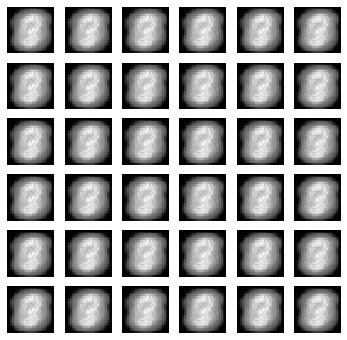

Epochs Progress, Training Iterations 599:  40%|████      | 4/10 [04:05<06:10, 61.80s/it]  INFO     | Training ... 


Epochs Progress, Training Iterations 180:  40%|████      | 4/10 [04:23<06:10, 61.80s/it]

In [ ]:
ae.fit(
    train_dataset=train_ds, 
    test_dataset=test_ds,
    instance_names=['image'],
    epochs=10,
    learning_rate=1e-3,
    random_latent=random_latent,
    recoding_dir=recoding_dir,
    gray_plot=True,
    generate_epoch=5,
    save_epoch=5,
    metric_epoch=10,
    gt_data=None
)

In [ ]:
#from ground_truth_datasets.datasets import load

In [ ]:
for batch in train_ds:
    image = batch['image'].numpy()[0]
    break

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(image.reshape(28,28))

In [ ]:
reconst = ae.decode(ae.encode(image))

In [ ]:
plt.imshow(reconst.numpy().reshape(28,28))